In [3]:
import os
import os.path as osp
from glob import glob
import re
from pprint import pprint
from tqdm import tqdm
import pydicom as dicom

PATHS = [f'/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p{s}' for s in range(10, 12)]

def check_dcm_extension(filename):
    pattern = r"\.dcm$"
    if re.search(pattern, filename):
        return True
    else:
        return False

def determine_view_position(dicom_file):
    # Load the DICOM file
    ds = dicom.dcmread(dicom_file)
    
    view_position = ds.ViewPosition
    
    if view_position == "PA" or view_position == "AP":
        return True
    elif view_position == "LATERAL":
        return "Lateral"
    else:
        return "Unknown"


In [4]:
ALL_IMG_PATHS = []

In [5]:
for PATH in PATHS:
    for dir_name in tqdm(os.listdir(PATH)):
        paths = os.listdir(osp.join(PATH, dir_name))
        img_dirs = [osp.join(PATH, dir_name, dir) for dir in paths if dir.find(".") == -1]
        for img_dir in img_dirs:
            img_paths = [osp.join(img_dir, img_name) for img_name in os.listdir(img_dir)]
            img_paths = [path for path in img_paths if check_dcm_extension(path)]
            ALL_IMG_PATHS.extend(img_paths)

100%|██████████| 6571/6571 [08:36<00:00, 12.72it/s]


In [6]:
len(ALL_IMG_PATHS)

75216

In [7]:
view_positions = []
for img_path in tqdm(ALL_IMG_PATHS):
    ds = dicom.dcmread(img_path, stop_before_pixels=True)
    view_positions.append(ds.ViewPosition)

100%|██████████| 75216/75216 [21:20<00:00, 58.72it/s] 


In [8]:
from collections import Counter
Counter(view_positions)

Counter({'AP': 29626,
         'PA': 19023,
         'LATERAL': 16310,
         'LL': 7024,
         '': 3231,
         'LAO': 1,
         'RAO': 1})

In [9]:
import string
import re

def append_whitespace(text):
    punctuations = set(string.punctuation)
    result = ''
    for char in text:
        if char in punctuations:
            result += ' ' + char
        else:
            result += char
    return result

def remove_duplicate_punctuation(text):
    punctuations = set(string.punctuation)
    result = []
    for char in text:
        if char in punctuations:
            if len(result) == 0 or result[-1] != char:
                result.append(char)
        else:
            result.append(char)
    return ''.join(result)

def swap_spaces(text):
    pattern = r'\s+'
    replacement = ' '
    result = re.sub(pattern, replacement, text)
    return result

def split_report_into_segment(report):
    report = report.replace('\n',' ')
    report = report.lower()
    report = remove_duplicate_punctuation(report)
    report = append_whitespace(report)
    report = swap_spaces(report)
    report = report.strip()
    return report

In [24]:
train_img_paths = []
train_txts = []

In [25]:
print(ALL_IMG_PATHS[40000])
print(ALL_IMG_PATHS[0])

/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11092156/s59657566/cbe1f343-02079f83-724c93b9-86b8cd1c-abf9f486.dcm
/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm


In [26]:
for img_path, view_position in tqdm(zip(ALL_IMG_PATHS, view_positions), total=len(ALL_IMG_PATHS)):
    if view_position in ["AP", "PA"]:
        dirs = img_path.split("/")
        p_dir = dirs[8]
        if p_dir in [f"p{i}" for i in range(10, 12)]: #todo fix this range
            txt_path = p_dir + "/" + "/".join(dirs[8:-1]) + ".txt"
            
            with open(txt_path, "r") as f:
                txt = f.read()
                
            txt = split_report_into_segment(txt)
            train_img_paths.append("/".join(dirs[8:]))

            train_txts.append(txt)

100%|██████████| 75216/75216 [01:55<00:00, 649.79it/s]


In [27]:
import csv

val_img_paths = train_img_paths[-200:]
val_train_txts = train_txts[-200:]

train_img_paths = train_img_paths[:-200]
train_txts = train_txts[:-200]

def create_tsv(img_paths, txts, split):
    with open(f"MIMIC_{split}.tsv", 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(["caption", "image"])
        for caption, img_name in tqdm(zip(txts, img_paths), total=len(txts)):
            writer.writerow([caption, img_name])

In [28]:
create_tsv(train_img_paths, train_txts, split="train")

100%|██████████| 48449/48449 [00:01<00:00, 48046.40it/s]


In [29]:
create_tsv(val_img_paths, val_train_txts, split="val")

100%|██████████| 200/200 [00:00<00:00, 39105.91it/s]


In [89]:
len(train_img_paths)

23611

In [37]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 7.4 MB/s eta 0:00:0000:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:0000:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [45]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

def show_image(xray_image):
    plt.imshow(xray_image, cmap="gray")

In [46]:
ds = dicom.dcmread("/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")

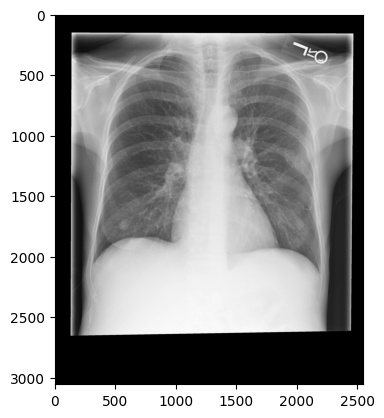

In [47]:
show_image(ds.pixel_array)

In [71]:
ds.ViewPosition

'LATERAL'

In [58]:
determine_view_position("/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.dcm")

'Lateral'

In [59]:
determine_view_position("/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")

'Frontal'